#Dimensionality reduction Autoencoder

In [ ]:
# -*- coding: utf-8 -*-

# Load required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import tensorflow.keras.optimizers as optimizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

#%%
# Declaring file names
# Path to input file
ip_training_file = "mirna_prot.csv"
# Path to output file
op_file = "AE_reduced_mirna_prot.csv"
# Save checkpoints while training
checkpoint_filepath = "AE_reduced_dataset_1_{epoch:02d}_{val_loss:.2f}.hdf5"
# Path to save AE loss image
fig_path =  "AE_reduced_dataset_1_loss.png"

#%%
# Data preprocessing
print("Reading data \n")
training_data = pd.read_csv(ip_training_file, index_col=0)
training_data.shape

# Train-test split
X_train, X_test, train_ground,valid_ground = train_test_split(training_data, training_data, test_size = 0.1, shuffle = True, random_state = 122131)
X_train.shape
X_test.shape

#%%
# Function to save weights when there is reduction in validation loss
model_checkpoint_callback = ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only = True, verbose = 1, monitor = 'val_loss', mode = 'min', save_best_only = True)

# Early stopping function i.e stop training the model if the validation loss remains same for five subsequent epochs
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5)

# Declare number of layers and nodes in each layer of AE
# Size of input data i.e dimension of input data, required to declare number of nodes in first and last layer of AE
ip_dim_size = X_train.shape[1]
# Size of encoded representations
encoding_dim_1 = 500
encoding_dim_2 = 100
encoding_dim_3 = 25



# Declare structure of AE
# Encoder section
# "encoded" is the encoded representation of the input
ip_dim_shape = Input(shape = (ip_dim_size,), name="input_layer")
x = Dense(encoding_dim_1, activation='relu', kernel_initializer = 'uniform', name = 'encoder_layer_1')(ip_dim_shape)
x = Dense(encoding_dim_2, activation='relu', kernel_initializer = 'uniform', name = 'encoder_layer_2')(x)
#x = Dense(encoding_dim_3, activation='relu', kernel_initializer = 'uniform', name = 'encoder_layer_3')(x)
#x = Dense(encoding_dim_4, activation='relu', kernel_initializer = 'uniform', name = 'encoder_layer_4')(x)
encoded = Dense(encoding_dim_2, activation='relu', kernel_initializer = 'uniform', name="bottleneck_layer")(x)

# Decoder section
# "decoded" is the lossy reconstruction of the input
#y = Dense(encoding_dim_4, activation='relu', kernel_initializer = 'uniform', name="decoder_layer_4")(encoded)
#y = Dense(encoding_dim_3, activation='relu', kernel_initializer = 'uniform', name="decoder_layer_3")(encoded)
y = Dense(encoding_dim_2, activation='relu', kernel_initializer = 'uniform', name="decoder_layer_2")(encoded)
y = Dense(encoding_dim_1, activation='relu', kernel_initializer = 'uniform', name="decoder_layer_1")(y)
decoded = Dense(ip_dim_size, activation='relu', kernel_initializer = 'uniform', name="op_layer")(y)

# This model maps an input to its reconstruction
autoencoder = Model(inputs = ip_dim_shape, outputs = decoded)
autoencoder.summary()

# Hyper-paramters to train the model
learning_rate = 0.001 # Vary or put in loop
batch_size = 24 # Vary depending on the memory of GPU
epochs = 200
# Initialize required optimizer with learning rate
opt_adam = optimizer.Adam(learning_rate = learning_rate)
# Compile the model
autoencoder.compile(optimizer = opt_adam, loss = 'mean_squared_error')

# Train/fit the model
estimator = autoencoder.fit(X_train, X_train, # input and output data
                epochs = epochs,
                batch_size = batch_size,
                shuffle = True,
                validation_data = (X_test, X_test), # Validation data
                callbacks = [early_stopping_callback, model_checkpoint_callback])

#%%
# Get reduced dimensional representation
# Get the encoder section of AE model
encoder = Model(inputs = ip_dim_shape, outputs = encoded)
# Get reduced dimension data for input data
bottleneck_representation = encoder.predict(training_data)
bottleneck_representation.shape
# Convert result to dataframe - required to write to csv file
bottleneck_representation_df = pd.DataFrame(data = bottleneck_representation, index = training_data.index)
print(bottleneck_representation_df.shape)
print(bottleneck_representation_df.iloc[0:5, 0:5])
# Write result to csv file
bottleneck_representation_df.to_csv(op_file, index = True)

#%%
# Obtain loss plot
print("Training Loss: ", estimator.history['loss'][-1])
print("Validation Loss: ", estimator.history['val_loss'][-1])
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper right')
plt.savefig(fig_path)
plt.close()

Reading data 

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 661)]             0         
                                                                 
 encoder_layer_1 (Dense)     (None, 500)               331000    
                                                                 
 encoder_layer_2 (Dense)     (None, 100)               50100     
                                                                 
 bottleneck_layer (Dense)    (None, 25)                2525      
                                                                 
 decoder_layer_2 (Dense)     (None, 100)               2600      
                                                                 
 decoder_layer_1 (Dense)     (None, 500)               50500     
                                                                 
 op_layer (Dense)            (None, 661)   

This code is repeated for each single omic separately, and for each combination. The following figure shows each combination with its AE architecture (mRNA is represented by L1, miRNA by L2, methylation by L3, and proteome by L4).


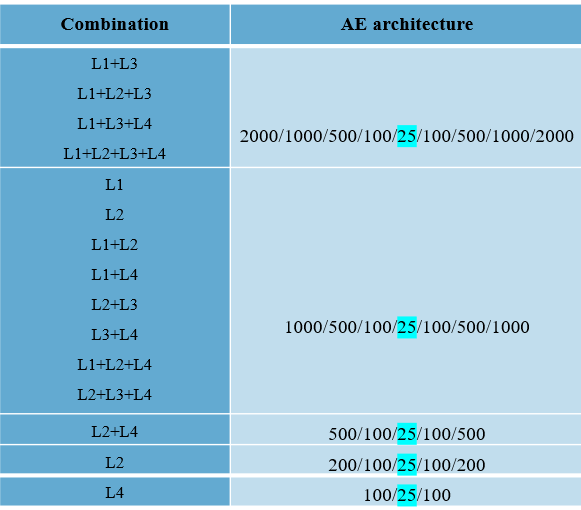



